# Behavior Pattern base on Sequence & Frequency

### Data Import

In [1]:
import pandas as pd
import numpy as np

# Read the CSV files into DataFrames
df_user = pd.read_csv('../2024初賽用開放資料/user_data.csv')
df_exam = pd.read_csv('../2024初賽用開放資料/dp001_exam.csv')
df_prac = pd.read_csv('../2024初賽用開放資料/dp001_prac.csv')
df_review = pd.read_csv('../2024初賽用開放資料/dp001_review.csv')
df_review_plus = pd.read_csv('../2024初賽用開放資料/dp001_review_plus.csv')
df_exam2 = pd.read_csv('../2024初賽用開放資料/dp002_exam.csv')
df_math = pd.read_csv('../2024初賽用開放資料/dp003_math.csv')
df_word = pd.read_csv('../2024初賽用開放資料/dp003_word.csv')



In [2]:
#查看 觀看動作(veiw_action) 唯一值
df_review_plus['view_action'].unique()

array(['browse', 'play', 'paused', 'normal', 'end', 'fuscreenon',
       'fuscreenoff', 'chkptstart', 'chkptend', 'continue', 'slowdown',
       'dragstart', 'dragleft', 'speedup', 'dragright', 'review',
       'question', 'note'], dtype=object)

### COMBINE Data Frame & EDA
繪製出了「圖一：各行爲次數」、「圖二：成績柱狀圖」、「圖三：label間的相關係數」


***

#### Plot 1 : 各個行為的次數

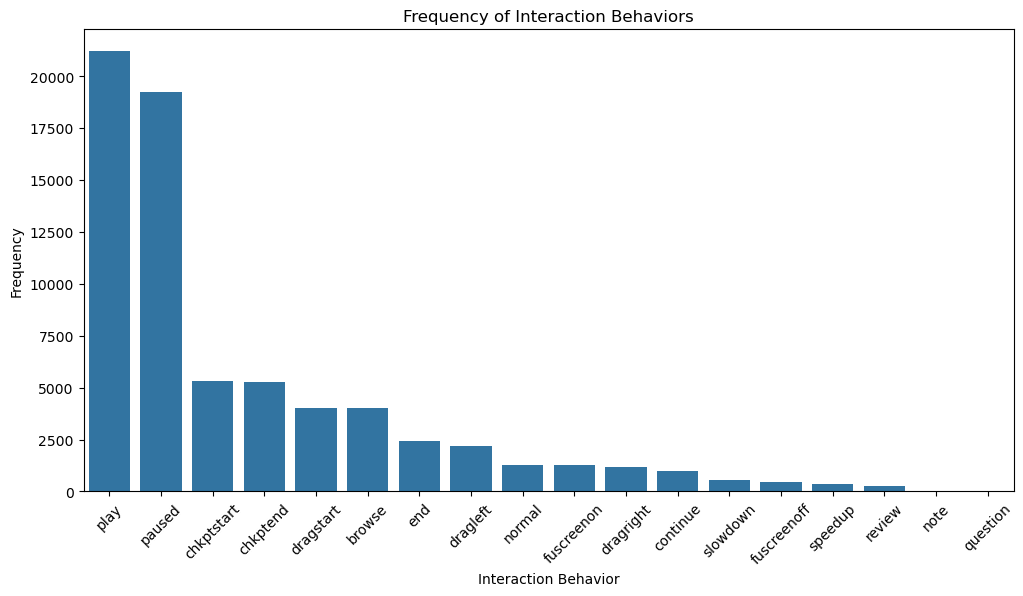

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Interaction Behavior Analysis
# Count each type of 'view_action' in df_review_plus to analyze behavior frequency
df_review_plus = df_review_plus.merge(df_review, on='review_sn', how='left')
behavior_counts = df_review_plus['view_action'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=behavior_counts.index, y=behavior_counts.values)
plt.title('Frequency of Interaction Behaviors')
plt.xlabel('Interaction Behavior')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


#### Plot 2 : 問題的成績分布、柱狀圖

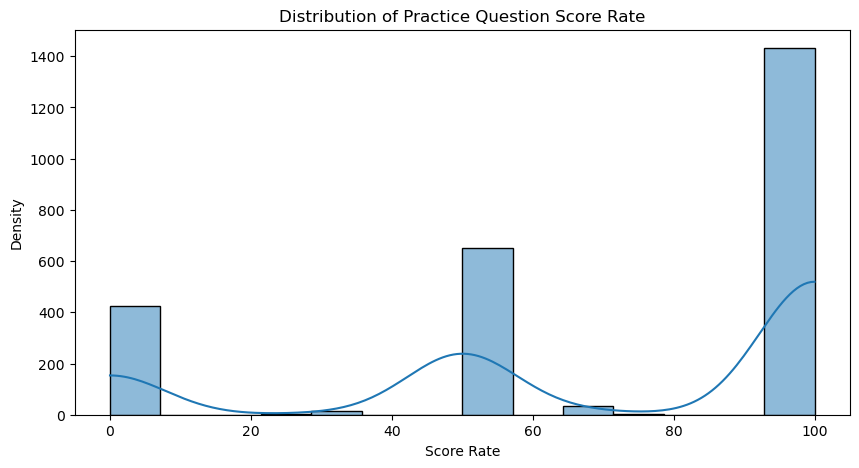

In [4]:

# Learning Outcomes Analysis
# Analyze the distribution of 'score_rate' in dp001_prac and correct response rate in dp001_exam
plt.figure(figsize=(10, 5))
sns.histplot(df_prac['score_rate'], kde=True)
plt.title('Distribution of Practice Question Score Rate')
plt.xlabel('Score Rate')
plt.ylabel('Density')
plt.show()


#### Plot 3 : 各個動作之間的皮爾森相似度

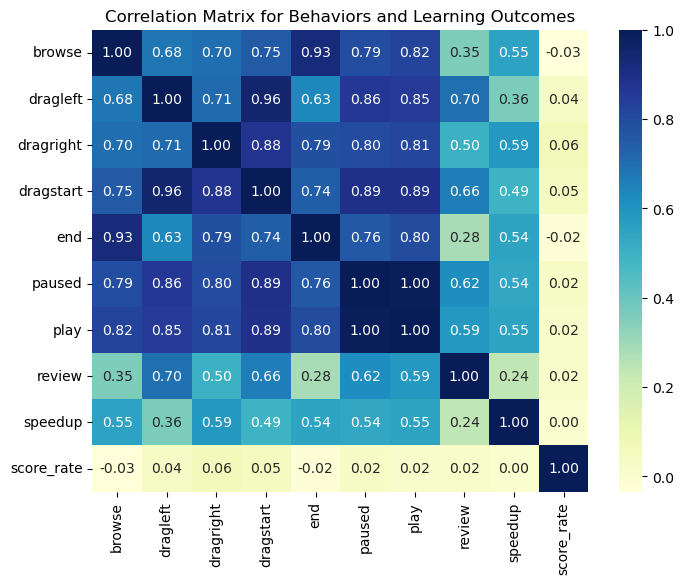

In [5]:

# Correlation Analysis: Merging behavior frequency and learning outcomes
# Summarize view_action by user_sn to calculate frequency of specific actions like replay and speedup
action_summary = df_review_plus.groupby(['user_sn', 'view_action']).size().unstack(fill_value=0)

# Merge with dp001_prac data for score_rate analysis
merged_df = pd.merge(action_summary, df_prac[['user_sn', 'score_rate']], on='user_sn', how='inner')

# Select only the relevant features for correlation analysis, excluding 'user_sn'
features_for_correlation = merged_df.drop(columns=['user_sn', 'normal', 'fuscreenon',
       'fuscreenoff', 'chkptstart', 'chkptend', 'continue', 'slowdown',
       'question', 'note'])

# Calculate the correlation matrix with the selected features
correlation_matrix = features_for_correlation.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Correlation Matrix for Behaviors and Learning Outcomes')
plt.show()


### Sequence Pattern Analysis 序列模式挖掘
比較經常出現特定行為序列的學生和未出現此行為序列的學生在學習成果上的差異。

*** 
識別序列：對每位學生，我們將識別常見的動作序列，特別是像「暫停 → 播放」、「重播 → 播放」等序列。
分析序列對分數比率的影響：計算經常出現特定序列的學生的平均分數比率，並與未出現這些序列的學生進行比較。

In [6]:
import pandas as pd

# Step 3.1: Identify sequences within each user's interactions
# Sort by user and timestamp to capture sequential behaviors
df_review_plus = df_review_plus.sort_values(by=['user_sn', 'view_time'])

# Create shifted columns to find sequences of actions
df_review_plus['next_action'] = df_review_plus.groupby('user_sn')['view_action'].shift(-1)

# Filter for specific sequences: 'paused' followed by 'play', and 'replay' followed by 'play'
paused_play_seq = df_review_plus[(df_review_plus['view_action'] == 'paused') & (df_review_plus['next_action'] == 'play')]
dragleft_play_seq = df_review_plus[(df_review_plus['view_action'] == 'dragleft') & (df_review_plus['next_action'] == 'play')]

# Count sequences for each user
paused_play_count = paused_play_seq.groupby('user_sn').size().rename('paused_play_count')
dragleft_play_count = dragleft_play_seq.groupby('user_sn').size().rename('dragleft_play_count')

# Merge sequence counts with score_rate data from dp001_prac
df_sequence_analysis = pd.DataFrame(df_prac[['user_sn', 'score_rate']])
df_sequence_analysis = df_sequence_analysis.merge(paused_play_count, on='user_sn', how='left').fillna(0)
df_sequence_analysis = df_sequence_analysis.merge(dragleft_play_count, on='user_sn', how='left').fillna(0)

# Step 3.2: Analyze the impact of sequences on score_rate
# Calculate average score_rate for users with and without each sequence type
avg_score_with_paused_play = df_sequence_analysis[df_sequence_analysis['paused_play_count'] > 0]['score_rate'].mean()
avg_score_without_paused_play = df_sequence_analysis[df_sequence_analysis['paused_play_count'] == 0]['score_rate'].mean()

avg_score_with_replay_play = df_sequence_analysis[df_sequence_analysis['dragleft_play_count'] > 0]['score_rate'].mean()
avg_score_without_replay_play = df_sequence_analysis[df_sequence_analysis['dragleft_play_count'] == 0]['score_rate'].mean()

print(f"Average score_rate for users with 'paused -> play' sequence: {avg_score_with_paused_play:.2f}")
print(f"Average score_rate for users without 'paused -> play' sequence: {avg_score_without_paused_play:.2f}")
print(f"Average score_rate for users with 'dragleft -> play' sequence: {avg_score_with_replay_play:.2f}")
print(f"Average score_rate for users without 'dragleft -> play' sequence: {avg_score_without_replay_play:.2f}")


Average score_rate for users with 'paused -> play' sequence: 67.75
Average score_rate for users without 'paused -> play' sequence: 78.17
Average score_rate for users with 'dragleft -> play' sequence: 68.24
Average score_rate for users without 'dragleft -> play' sequence: 73.14


根據上述的內容可以得知：
* users with 'paused -> play' 分數較低可能是呈現出較高的**認知負荷**因此學習成就較為低落
* users without 'paused -> play' 分數較高可能是呈現出較低的**認知負荷**因此學習成就較高
同理 users with/without 'dragleft -> play'

### Lag Sequential Analysis
使用滯後序列進行行為模式的挖掘

使用滯後序列分析來看行為(view_aciton)之間與學習成就有無關聯

In [23]:
# 查看 df_review_plus 的資料摘要
#print("Data Summary:")
#print(df_review_plus.info())

# 顯示資料框架的前幾行
#print("\nFirst few rows of df_review_plus:")
#print(df_review_plus.head())

#顯示記錄view_action時間戳記view_action
#print("\nTimestamp heads:")
#print(df_review_plus['view_time'].head())

轉換 view_time 為適合分析的格式  
為了能夠計算行為之間的滯後時間，需要將 view_time 轉換為可計算的時間格式。

In [8]:
# 確保 view_time 是字串格式後進行轉換
df_review_plus['view_time'] = pd.to_datetime(df_review_plus['view_time'], format='%Y-%m-%d %H:%M:%S')

# 檢查轉換後的資料類型
print("Converted 'view_time' type:", df_review_plus['view_time'].dtype)

# 檢查時間範圍
print("Timestamp range:", df_review_plus['view_time'].min(), "-", df_review_plus['view_time'].max())


Converted 'view_time' type: datetime64[ns]
Timestamp range: 2024-01-02 07:38:34 - 2024-05-31 13:05:55


 根據用戶和時間排序行為序列  
為了提取滯後行為序列，資料需要按照用戶 (user_sn) 和時間 (view_time) 排序。

In [9]:
# 按 user_sn 和 view_time 排序
df_review_plus = df_review_plus.sort_values(by=['user_sn', 'view_time'])

# 檢查排序後的資料
print(df_review_plus[['user_sn', 'view_action', 'view_time']].head(10))

       user_sn view_action           view_time
27263     4561      browse 2024-03-10 20:38:38
27264     4561        play 2024-03-10 20:38:52
27265     4561      paused 2024-03-10 20:40:43
32081     4561      browse 2024-03-24 14:02:32
32082     4561        play 2024-03-24 14:02:46
32083     4561      paused 2024-03-24 14:02:47
32084     4561        play 2024-03-24 14:02:57
32085     4561    slowdown 2024-03-24 14:03:07
32086     4561      normal 2024-03-24 14:03:08
32087     4561      paused 2024-03-24 14:03:31


生成滯後行為與時間差  
使用 .shift() 方法計算每個行為的滯後行為和滯後時間差。

In [10]:
# 添加上一個行為及其滯後時間差
df_review_plus['prev_action'] = df_review_plus.groupby('user_sn')['view_action'].shift(1)
df_review_plus['time_diff'] = df_review_plus.groupby('user_sn')['view_time'].diff().dt.total_seconds()
# 過濾掉缺失值的行
df_review_plus = df_review_plus.dropna(subset=['prev_action', 'time_diff'])
# 設置時間差窗口，例如小於 300 秒（5 分鐘）
df_review_plus = df_review_plus[df_review_plus['time_diff'] <= 300]
# 檢查滯後行為與時間差
print(df_review_plus[['user_sn', 'view_action', 'prev_action', 'time_diff']].head(10))


       user_sn view_action prev_action  time_diff
27264     4561        play      browse       14.0
27265     4561      paused        play      111.0
32082     4561        play      browse       14.0
32083     4561      paused        play        1.0
32084     4561        play      paused       10.0
32085     4561    slowdown        play       10.0
32086     4561      normal    slowdown        1.0
32087     4561      paused      normal       23.0
32088     4561        play      paused       39.0
32089     4561      paused        play      107.0


檢查 time_diff 的分布，判斷數據是否有特別的地方。

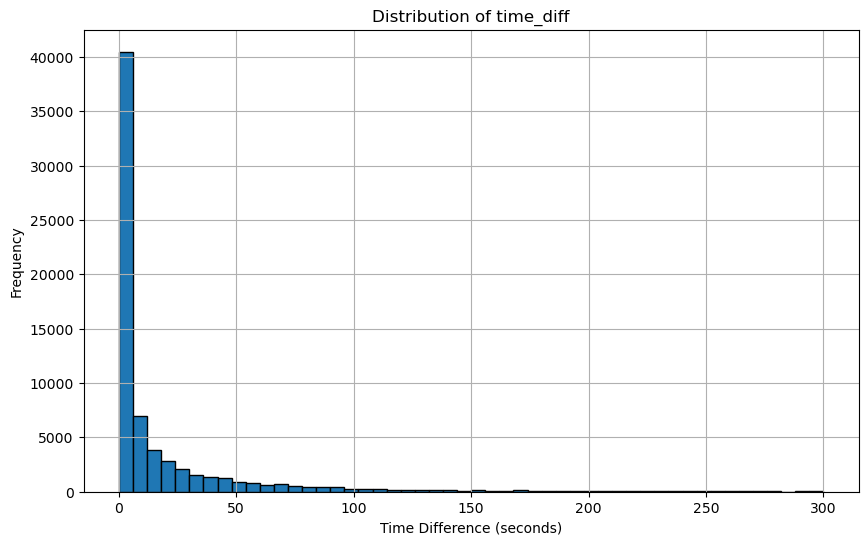

In [11]:
import matplotlib.pyplot as plt

# 繪製 time_diff 的分布
plt.figure(figsize=(10, 6))
df_review_plus['time_diff'].dropna().hist(bins=50, edgecolor='k')
plt.title('Distribution of time_diff')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.show()


In [25]:
# 篩選特定的行為序列
filtered_sequences = df_review_plus[
    (df_review_plus['prev_action'] == 'paused') &  # 前一個行為為 paused
    (df_review_plus['view_action'] == 'play') &   # 當前行為為 play
    (df_review_plus['time_diff'] <= 300)            # 滯後時間小於等於 5 秒
]

# 查看篩選結果
#print("Filtered sequences (paused -> play within 5 seconds):")
#print(filtered_sequences[['user_sn', 'prev_action', 'view_action', 'time_diff']].head())


上述的程式碼解決了選定的特定序列  
後續會針對序列次數以及學習成績做分析
因此會先計算平均的score_rate

In [26]:
# 計算每個用戶的序列次數
sequence_counts = filtered_sequences.groupby('user_sn').size().reset_index(name='sequence_count')

# 查看結果
#print("Sequence counts per user:")
#print(sequence_counts.head())


In [18]:
# 計算每個用戶的平均 score_rate
user_avg_score_rate = df_prac.groupby('user_sn', as_index=False)['score_rate'].mean()

# 查看結果
print("User average score_rate:")
print(user_avg_score_rate.head())


User average score_rate:
   user_sn  score_rate
0     4381   63.300000
1     4561   82.706767
2     6828   79.166667
3     8634   61.627907
4    11303   42.708333


In [19]:
# 合併序列次數與平均 score_rate
user_sequence_data = sequence_counts.merge(user_avg_score_rate, on='user_sn', how='left')

# 查看合併結果
print("User sequence data with average score_rate:")
print(user_sequence_data.head())


User sequence data with average score_rate:
   user_sn  sequence_count  score_rate
0     4561               3   82.706767
1     8634              75   61.627907
2    11303              56   42.708333
3    11312             333   86.918919
4    13328              59   65.972222


從下列的圖表中可以觀察到pause -> play的次數與成績並沒有顯著的相關性

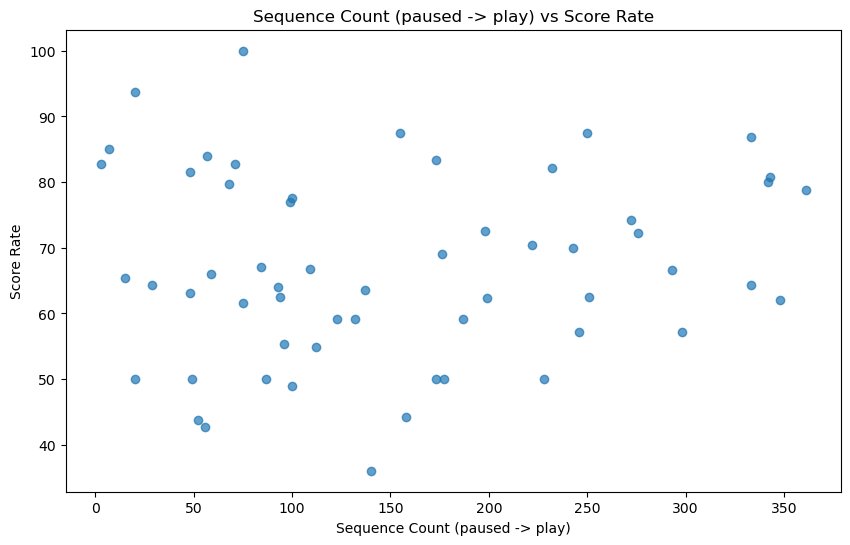

In [22]:
import matplotlib.pyplot as plt

# 繪製散佈圖
plt.figure(figsize=(10, 6))
plt.scatter(user_sequence_data['sequence_count'], user_sequence_data['score_rate'], alpha=0.7)
plt.title('Sequence Count (paused -> play) vs Score Rate')
plt.xlabel('Sequence Count (paused -> play)')
plt.ylabel('Score Rate')
plt.show()


### Clustering Analysis
讓我們基於行為頻率進行聚類分析，將具有相似互動模式的學生分組，並分析這些群組在分數比率上的差異。這將有助於我們了解某些行為群組是否在學習成果上持續表現出較高或較低的成績。


#### Part 1
準備分群的資料（根據各個行爲的次數）


In [39]:
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Prepare behavior frequency data for clustering
# Aggregate behavior counts per user
behavior_features = df_review_plus.groupby('user_sn')['view_action'].value_counts().unstack(fill_value=0)
# 查看聚類特徵矩陣的前幾行
print(behavior_features.columns)


Index(['browse', 'chkptend', 'chkptstart', 'continue', 'dragleft', 'dragright',
       'dragstart', 'end', 'fuscreenoff', 'fuscreenon', 'normal', 'note',
       'paused', 'play', 'question', 'review', 'slowdown', 'speedup'],
      dtype='object', name='view_action')


Average score_rate by cluster:
cluster
0    73.480519
1    66.499085
2    71.813830
Name: score_rate, dtype: float64


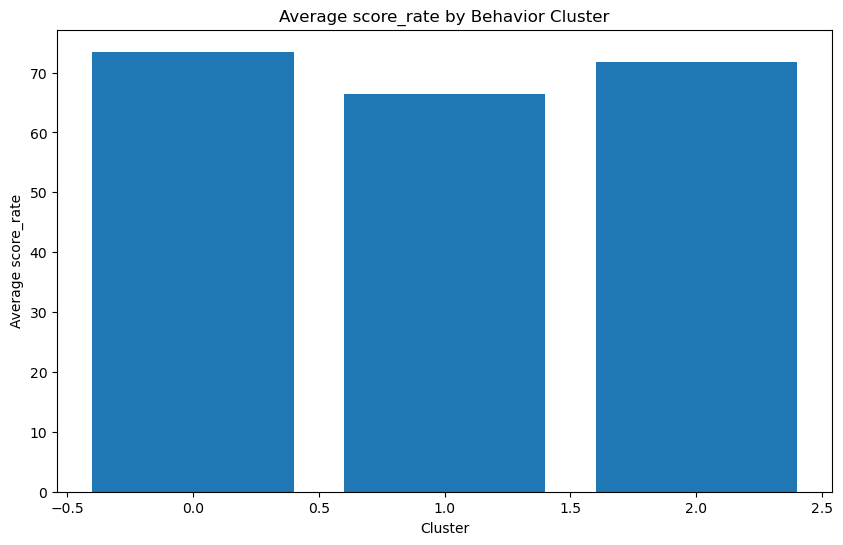

In [ ]:

# Step 2: Apply K-means clustering
# Choose an appropriate number of clusters (e.g., 3) for initial analysis
kmeans = KMeans(n_clusters=3, random_state=42)
behavior_features['cluster'] = kmeans.fit_predict(behavior_features)

# Step 3: Merge clusters with score_rate data
clustered_data = behavior_features.merge(df_prac[['user_sn', 'score_rate']], on='user_sn', how='left')

# Step 4: Calculate the average score_rate for each cluster
cluster_avg_scores = clustered_data.groupby('cluster')['score_rate'].mean()
print("Average score_rate by cluster:")
print(cluster_avg_scores)

# Optional: Plot the clusters to visualize behavior patterns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(cluster_avg_scores.index, cluster_avg_scores.values)
plt.xlabel('Cluster')
plt.ylabel('Average score_rate')
plt.title('Average score_rate by Behavior Cluster')
plt.show()


計算並視覺化每個群組在不同行為特徵上的平均值

<Figure size 1200x800 with 0 Axes>

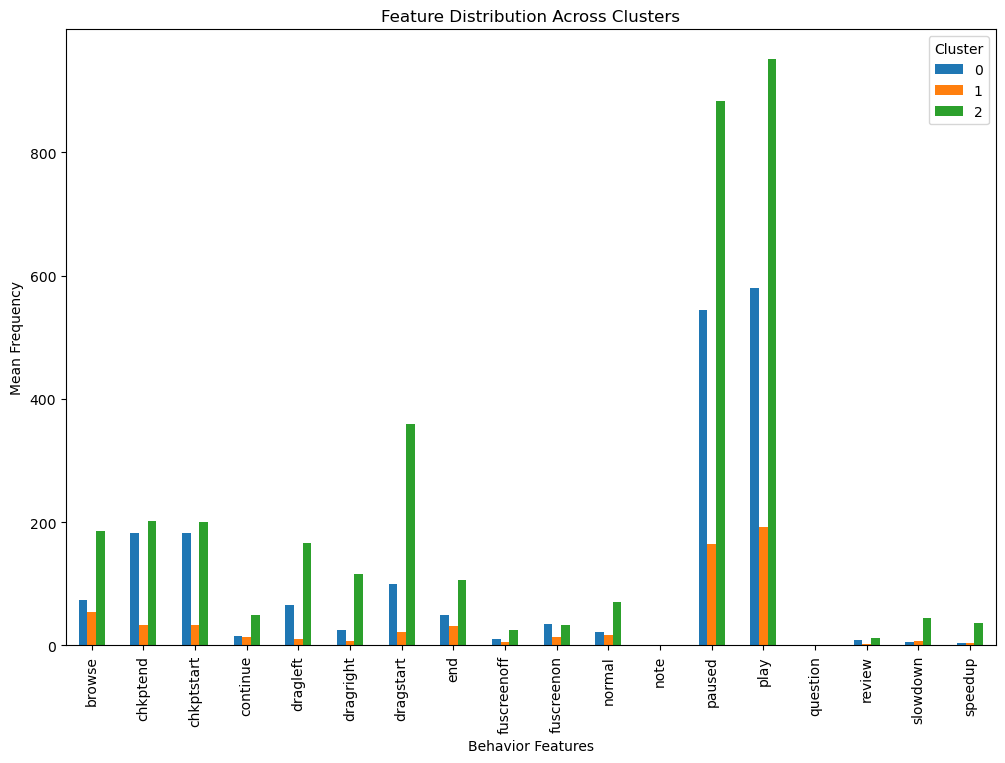

In [41]:
# 計算每個群組的labal平均值
cluster_feature_means = behavior_features.groupby('cluster').mean()

# 繪製特徵分布的條形圖
import seaborn as sns

plt.figure(figsize=(12, 8))
cluster_feature_means.T.plot(kind='bar', figsize=(12, 8))
plt.title('Feature Distribution Across Clusters')
plt.xlabel('Behavior Features')
plt.ylabel('Mean Frequency')
plt.legend(title='Cluster')
plt.show()


Average score_rate by cluster:
cluster
0    73.480519
1    66.499085
2    71.813830
Name: score_rate, dtype: float64


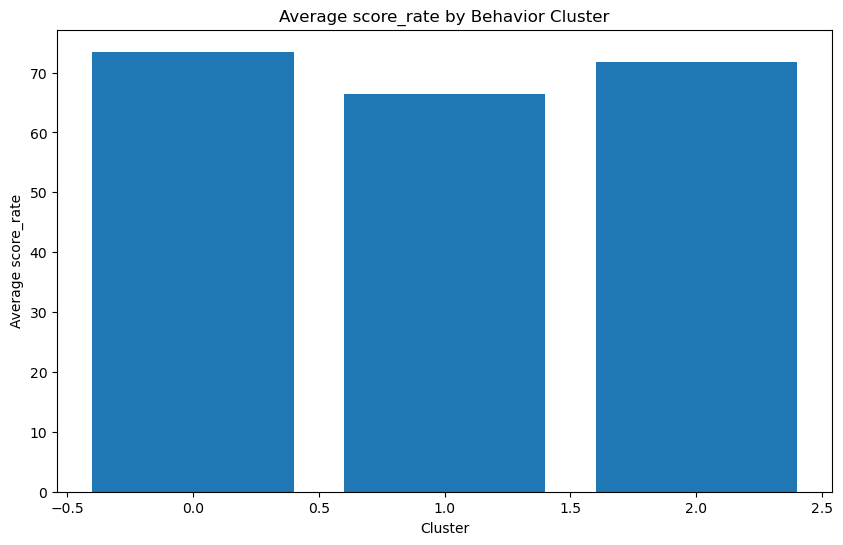

In [42]:

# Step 3: Merge clusters with score_rate data
clustered_data = behavior_features.merge(df_prac[['user_sn', 'score_rate']], on='user_sn', how='left')

# Step 4: Calculate the average score_rate for each cluster
cluster_avg_scores = clustered_data.groupby('cluster')['score_rate'].mean()
print("Average score_rate by cluster:")
print(cluster_avg_scores)

# Optional: Plot the clusters to visualize behavior patterns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(cluster_avg_scores.index, cluster_avg_scores.values)
plt.xlabel('Cluster')
plt.ylabel('Average score_rate')
plt.title('Average score_rate by Behavior Cluster')
plt.show()


### Prediction Phase(Failed)
為了量化這些行為模式對score_rate的影響，我們可以繼續進行預測建模。

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Step 1: Prepare data with behavior frequencies and sequence counts as features
# We'll use `behavior_features` from the previous clustering analysis and add sequence counts
df_features = behavior_features.copy()
df_features = df_features.merge(df_sequence_analysis[['user_sn', 'paused_play_count', 'dragleft_play_count', 'score_rate']], on='user_sn', how='left')

# Separate features and target variable
X = df_features.drop(columns=['user_sn', 'score_rate'])  # Features: behavior frequencies and sequence counts
y = df_features['score_rate']  # Target variable

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Modeling - Using Random Forest as an example
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 4: Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 32.28
R² Score: 0.06


平均絕對誤差 （MAE） 為 32.28 表明平均預測誤差相對較高，這意味著模型的預測與實際score_rate相差甚遠。
R² 分數為 0.06 意味著該模型僅解釋了 score_rate 方差的 6%，表明交互行為與學習結果之間的關係較弱。

此結果表明，所選行為模式（如暫停、播放、向左拖動等頻率，以及特定序列（如暫停 -> 播放）可能不會對score_rate產生重大影響。其他因素，可能在交互行為數據之外，可能對決定學習結果更有影響。